# Measure Predicted Changes in Phase Diagrams
Given a list of compounds that are predicted to be stable by Dipendra's DL model, measure changes in the phase diagrams.

In [2]:
%matplotlib inline
from pymatgen import Composition, Element
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.plotter import PDPlotter
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.phasediagram.analyzer import PDAnalyzer
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from pathos.multiprocessing import ProcessingPool as Pool
import itertools
import os
import re
import pandas as pd
import numpy as np

In [3]:
pool = Pool(processes=os.cpu_count())

## Load in the OQMD data

In [4]:
oqmd_data = pd.read_csv('oqmd_all.txt', delim_whitespace=True)
print('Read in %d entries'%len(oqmd_data))

Read in 506114 entries


/home/wardlt/software/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rename `comp` to `composition` (you'll thank me later)

In [5]:
oqmd_data.rename(columns={'comp':'composition'}, inplace=True)
oqmd_data.head()

,composition,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.892,17.8351,None,0.0,0.015186,0.0151862666667
1,Mg1,-1.5396,22.9639,None,0.0,0.002912,0.0029123775
2,Kr1,0.011256,41.4146,None,7.367,0.015315,0.015314775
3,Na1,-1.2991,32.9826,None,0.0,0.003780,0.00377956333333
4,Pd1,-5.15853,15.2088,None,0.0,0.018186,0.0181856433333


Eliminate entries with no `delta_e`

In [6]:
oqmd_data = oqmd_data[~ oqmd_data['delta_e'].isnull()]
print('%d entries with delta_e'%len(oqmd_data))

506114 entries with delta_e


Eliminate insanely low formation enthalpies

In [7]:
oqmd_data = oqmd_data.query('delta_e > -10')

In [8]:
oqmd_data.describe()

,delta_e
count,506113.000000
mean,-0.072298
std,2.306472
min,-5.620103
25%,-0.312292
50%,0.066099
75%,0.395459
max,1126.312155


Convert this data to PDEntries. This is what `pymatgen`'s PhaseDiagram creates

In [10]:
%%time
def get_pdentry(row, attribute=None):
    comp = Composition(row['composition'])
    return PDEntry(comp.fractional_composition, row['delta_e'], comp.reduced_formula, attribute)
oqmd_data['pdentry'] = oqmd_data.apply(lambda x: get_pdentry(x, 'oqmd'), axis=1)

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


CPU times: user 1min 57s, sys: 492 ms, total: 1min 58s
Wall time: 1min 57s


List out the system for each entry

In [11]:
elem_re = re.compile('[A-Z][a-z]?')
def get_elems(s):
    return ''.join(sorted(set(elem_re.findall(s))))
assert get_elems('AlFeFe2') == 'AlFe'
oqmd_data['system'] = oqmd_data['composition'].apply(get_elems)

Make a function to get data from a single system

In [12]:
def get_data_from_system(data, system):
    """Extract rows from a pandas array that are in a certain phase diagram
    
    :param data: DataFrame, data from which to query. Must contain column "system"
    :param system: list/set, list of elements to serve as input
    :return: DataFrame, with only entries that exclusively contain these elements"""
    
    # Get the systems that make up this phase diagram
    constit_systems = set()
    for sys in itertools.product(system, repeat=len(system)):
        constit_systems.add(''.join(sorted(set(sys))))
    
    # Get all points that are at any of those systems
    query_str = ' or '.join(['system == "%s"'%s for s in constit_systems])
    return data.query(query_str)
    
assert set(get_data_from_system(oqmd_data, ['Al','Ni','Zr'])['system']) == {'Al', 'Ni', 'Zr', 'AlNi', 'AlZr', 'NiZr', 'AlNiZr'}

Plot one of the ternary diagrams. This chart shows the compositions of stable phases in the Te-Ni-Hf system. Stable phases are those on the convex hull.

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


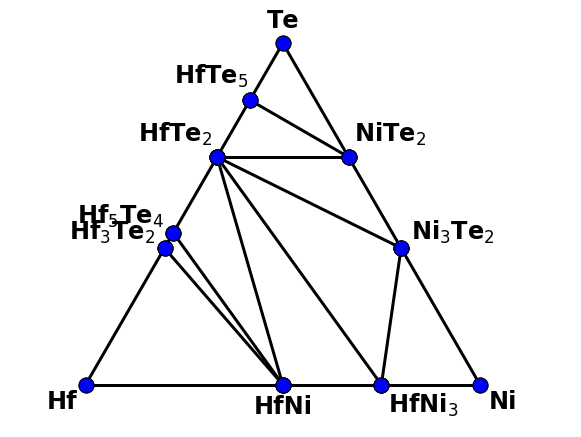

In [13]:
pdg = PhaseDiagram(get_data_from_system(oqmd_data, ['Te', 'Ni', 'Hf'])['pdentry'])
PDPlotter(pdg).show()

### Compute the number of stable entries in each phase diagram
This is our "baseline" measurement for what the diagrams look like before deep learning

#### Get the lists of systems to search
Counting the number of stable phases in each system could take a very 

In [14]:
element_list = set()
oqmd_data['composition'].apply(lambda x: element_list.update(elem_re.findall(x)))
print('Number of elements:', len(element_list))

Number of elements: 89


Get certain groups of elements

In [15]:
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe']
alkali_metals = ['Li', 'Na', 'K'] # , 'Rb', 'Cs'] - Only do the common ones
threed_tms = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']
actinides = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu'] # VASP only has these
lanthanides = [Element.from_Z(x).symbol for x in range(57, 72)]
tms = [Element.from_Z(x).symbol for x in range(1,102) if Element.from_Z(x).is_transition_metal > 0]

Remove noble gases, lanthanides, and actinides

In [16]:
element_list.difference_update(noble_gases)
element_list.difference_update(actinides)
element_list.difference_update(lanthanides)
print('Number of elements:', len(element_list))

Number of elements: 63


Get all of the binary systems

In [17]:
def assemble_list_of_systems(order):
    """Create a DataFrame of all possible systems with a certain number of elements"""
    output = pd.DataFrame()
    output['system'] = list(itertools.combinations(element_list, order))
    return output
binary_systems = assemble_list_of_systems(2)
print('Generated %d binary systems'%len(binary_systems))

Generated 1953 binary systems


Get the ternary systems that contain an common Alkali metal

In [18]:
ternary_systems = assemble_list_of_systems(3)
ternary_systems = ternary_systems[[any([x in s for x in alkali_metals]) for s in ternary_systems['system']]]
print('Generated %d ternary systems'%len(ternary_systems))

Generated 5491 ternary systems


Get quarternary systems that contain at least 3 3d TMs

LW 2June17: I made these filters stringent to keep runtimes down.

In [19]:
quaternary_systems = assemble_list_of_systems(4)
quaternary_systems = quaternary_systems[[
    sum([x in threed_tms for x in s]) >= 3 and all([x in tms for x in s]) for s in quaternary_systems['system']]]
print('Generated %d quaternary systems'%len(quaternary_systems))

Generated 2490 quaternary systems


#### Count the number of stable systems
Using the already-computed hull distances, count how many stable phases there are

In [20]:
%%time
def find_number_of_stable_compounds(systems, data, colname):
    """Count the number of stable compounds in a list of systems
    
    :param systems: DataFrame, list of systems to evaluate
    :param data: DataFrame, stability data to use
    :param colname: str, name of output column in `systems`"""
    def count_stable(system):
        pdf = PhaseDiagram(get_data_from_system(data, system)['pdentry'])
        return len(pdf.stable_entries)
    systems[colname] = systems['system'].apply(count_stable)
find_number_of_stable_compounds(binary_systems, oqmd_data, 'oqmd_stable')

CPU times: user 2min 59s, sys: 245 ms, total: 2min 59s
Wall time: 2min 59s


Repeat this for the binary and ternary cases

In [21]:
%%time
for systems in [ternary_systems, quaternary_systems]:
    find_number_of_stable_compounds(systems, oqmd_data, 'oqmd_stable')

CPU times: user 37min 42s, sys: 4.08 s, total: 37min 46s
Wall time: 37min 42s


Which are the binary systems with the greatest number of stable phases?

In [22]:
binary_systems.sort_values('oqmd_stable', ascending=False).head()

,system,oqmd_stable
575,"(O, Ti)",10
1329,"(Ca, Au)",10
382,"(Mg, Pd)",9
56,"(Zr, Te)",8
1327,"(Ca, Pd)",8


In [23]:
binary_systems.to_csv('binary_systems.csv', index=False)

## Assess the effect of adding DL predictions
Look at several things:
1. In which systems did DL predict the most stable compositions
2. In which systems the the convex hull change the most

In [24]:
%%time
def load_DL_predictions(path):
    """Loads in the predictions from Dipendra, and renames the `delta_e` column to match the `oqmd_data`
    
    Also generates a `PDEntry` for each composition, and computes which system this entry is in
    """
    output = pd.read_csv(path, sep=' ')
    output.rename(columns={'delta_e_predicted': 'delta_e'}, inplace=True)
    output['pdentry'] = output.apply(get_pdentry, axis=1)
    output['system'] = output['composition'].apply(get_elems)
    return output
dl_binary = load_DL_predictions(os.path.join('new-datasets', 'binary_stable-0.2.data.gz'))

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


CPU times: user 597 ms, sys: 2 ms, total: 599 ms
Wall time: 596 ms


### Specific Diagrams
These generally are the systems with the greatest number of stable compounds, as identified in [where-are-stable-compounds.ipynb](where-are-stable-compounds.ipynb)

Update data with both binary and ternary datasets

In [25]:
updated_oqmd_data = oqmd_data.append(dl_binary)

In [26]:
%%time
updated_oqmd_data = updated_oqmd_data.append(load_DL_predictions(os.path.join('new-datasets', 'ternary_stable-0.2.data.gz')))

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


CPU times: user 1min 3s, sys: 339 ms, total: 1min 3s
Wall time: 1min 3s


Ternary systems to assess

In [27]:
ternary_choices = []

### Binary Systems
Assess the changes to phase diagrams after adding new binary data points

Update the OQMD data with these new values, and recompute the phase diagrams

In [28]:
%%time
find_number_of_stable_compounds(binary_systems, updated_oqmd_data, 'with_DL')

CPU times: user 4min 28s, sys: 272 ms, total: 4min 28s
Wall time: 4min 27s


Figure out how many diagrams changed

In [29]:
binary_systems['new_compounds'] = binary_systems['with_DL'] - binary_systems['oqmd_stable']

Which had the greatest number of new compounds

In [30]:
binary_systems.sort_values('new_compounds', ascending=False).head()

,system,oqmd_stable,with_DL,new_compounds
1520,"(F, Co)",4,10,6
795,"(Fe, F)",4,10,6
648,"(Ti, F)",3,9,6
1103,"(K, F)",3,9,6
933,"(In, F)",3,7,4


Plot one of them

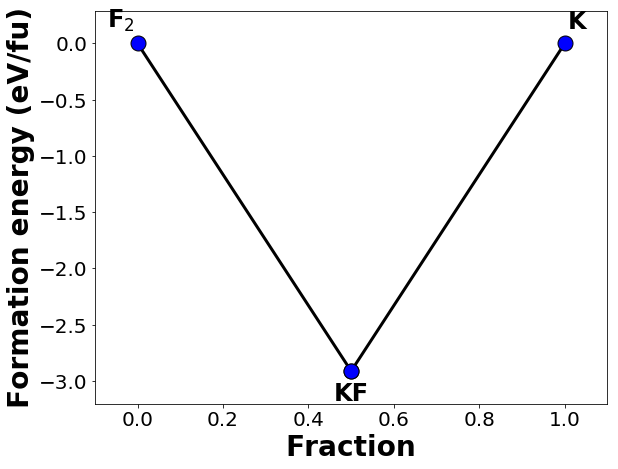

In [31]:
pdg = PhaseDiagram(get_data_from_system(oqmd_data, 
                                        binary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[3])
                  ['pdentry'])
PDPlotter(pdg).show()

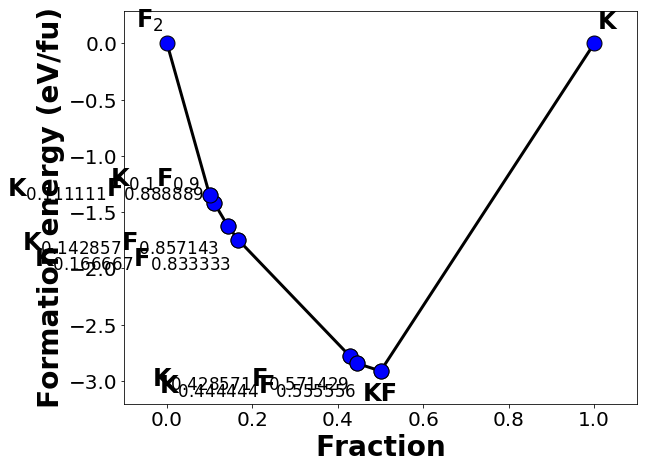

In [32]:
pdg = PhaseDiagram(get_data_from_system(updated_oqmd_data, 
                                        binary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[3])
                  ['pdentry'])
PDPlotter(pdg).show()

### Ternary Systems
Add in ternary data, reassess ternaries

Update the ternary systems

In [33]:
%%time
find_number_of_stable_compounds(ternary_systems, updated_oqmd_data, 'with_DL')
ternary_systems['new_compounds'] = ternary_systems['with_DL'] - ternary_systems['oqmd_stable']

CPU times: user 28min 56s, sys: 2.58 s, total: 28min 58s
Wall time: 28min 55s


Plot which have the most numbers of new compounds

In [34]:
ternary_systems.sort_values('new_compounds', ascending=False, inplace=True)
ternary_systems.head()

,system,oqmd_stable,with_DL,new_compounds
35809,"(F, As, Na)",8,26,18
28620,"(K, F, Si)",8,26,18
6992,"(Rh, P, Li)",11,29,18
10325,"(Br, Na, Te)",8,26,18
28624,"(K, F, P)",9,27,18


/home/wardlt/software/miniconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


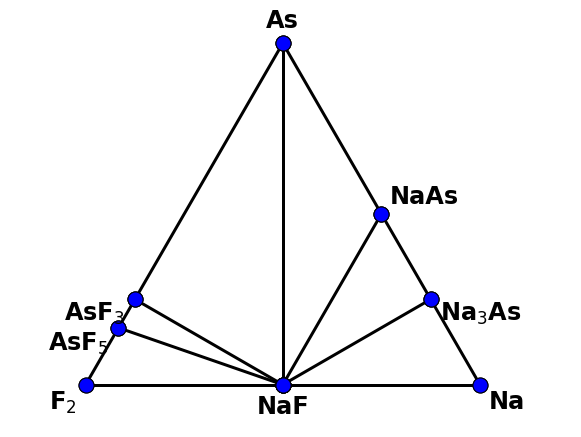

In [35]:
pdg = PhaseDiagram(get_data_from_system(oqmd_data, 
                                        ternary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[0])
                  ['pdentry'])
PDPlotter(pdg).show()

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


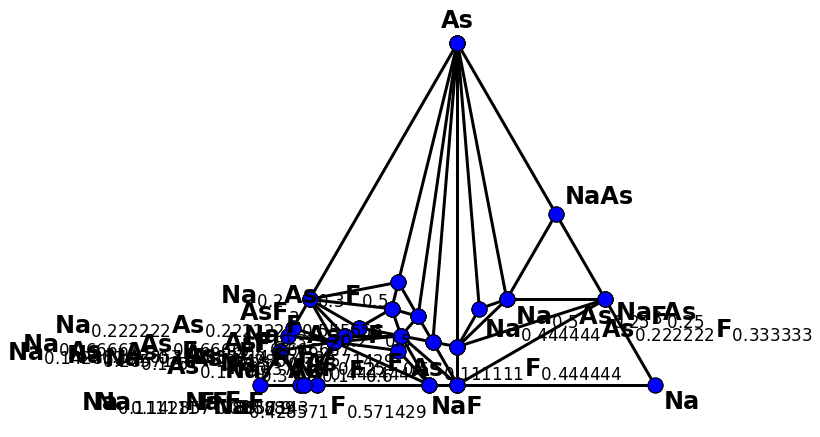

In [36]:
pdg = PhaseDiagram(get_data_from_system(updated_oqmd_data, 
                                        ternary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[0])
                  ['pdentry'])
PDPlotter(pdg).show()

In [37]:
def get_clusters(system, data=updated_oqmd_data):
    """Get the distinct clusters of compounds within the predictions
    
    :param pdg: PhaseDiagram, phase diagram to analyze
    :return: list of compositions to pick"""
    
    pdg = PhaseDiagram(get_data_from_system(data, system)['pdentry'])
    
    # Get the DL predictions
    stable_dl = [x for x in pdg.stable_entries if x.attribute is not 'oqmd']
    
    # Convert compositions to vectors
    comps = np.zeros((len(stable_dl), len(system)))
    for j,e in enumerate(system):
        for i,c in enumerate(stable_dl):
            comps[i,j] = c.composition[e]

    # Determine the "unclustered" score
    score = 0
    best_labels = [0,]*len(comps)

    # Determine the optimal number of clusters
    ac = AgglomerativeClustering()
    best_score = -1
    for size in range(2,5):
        ac.set_params(n_clusters=size)
        labels = ac.fit_predict(comps)
        score = silhouette_score(comps, labels)
        if score > best_score:
            best_labels = labels
            best_score = score
    
    # Get the best labels for each cluster
    output = []
    for cluster in range(best_labels.max()+1):
        # Get the points in the cluster
        my_points = comps[best_labels==cluster]
        
        # Get the point closest to the center
        my_dists = np.power(my_points - my_points.mean(axis=0), 2).sum(axis=1)
        output.append(Composition(dict((e,c) for e,c in zip(system,my_points[my_dists.argmin(),:]))).reduced_formula)
        
    return output
get_clusters(['K','Si','F'])

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


['K0.125Si0.125F0.75', 'K0.4Si0.1F0.5']

In [38]:
ternary_systems.iloc[:10]

,system,oqmd_stable,with_DL,new_compounds
35809,"(F, As, Na)",8,26,18
28620,"(K, F, Si)",8,26,18
6992,"(Rh, P, Li)",11,29,18
10325,"(Br, Na, Te)",8,26,18
28624,"(K, F, P)",9,27,18
28627,"(K, F, Cl)",7,24,17
21565,"(Fe, K, F)",8,25,17
28618,"(K, F, Co)",7,24,17
28391,"(K, Cu, F)",6,23,17
28642,"(K, F, Tl)",8,24,16


In [39]:
ternary_systems.to_csv('ternary_systems.csv', index=False)

In [40]:
best_ternary_systems = ternary_systems.iloc[:10].copy()
best_ternary_systems['choices'] = best_ternary_systems['system'].apply(get_clusters)

In [ ]:
best_ternary_systems.to_csv('best_ternaries.csv', index=False)

## Quaternary Systems
Same thing, but with quaternaries

In [ ]:
%%time
updated_oqmd_data = updated_oqmd_data.append(load_DL_predictions(os.path.join('new-datasets', 'quaternary_stable-0.2.data.gz')))

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/miniconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


CPU times: user 41min 24s, sys: 15.5 s, total: 41min 40s
Wall time: 41min 36s


Update the counts of stable compounds

In [ ]:
%%time
find_number_of_stable_compounds(quaternary_systems, updated_oqmd_data, 'with_DL')
quaternary_systems['new_compounds'] = quaternary_systems['with_DL'] - quaternary_systems['oqmd_stable']

In [ ]:
quaternary_systems.sort_values('new_compounds', ascending=False).head()

In [ ]:
quaternary_systems.to_csv('quaternary_systems.csv', index=False)

In [ ]:
best_quaternary_systems = quaternary_systems.iloc[:10].copy()
best_quaternary_systems['choices'] = best_quaternary_systems['system'].apply(get_clusters)

In [ ]:
best_quaternary_systems.to_csv('best_quaternaries.csv', index=False)